In [46]:
import numpy as np
import nibabel as nib
import utils.class_functions
import numpy as np
def get_bbox3d(mask_volume: np.ndarray):
    """Return 6 coordinates of a 3D bounding box from a given mask.

    Taken from `this SO question <https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array>`_.

    Args:
        mask_volume: 3D NumPy array.
    """  # noqa: B950
    i_any = np.any(mask_volume, axis=(1, 2))
    j_any = np.any(mask_volume, axis=(0, 2))
    k_any = np.any(mask_volume, axis=(0, 1))
    i_min, i_max = np.where(i_any)[0][[0, -1]]
    j_min, j_max = np.where(j_any)[0][[0, -1]]
    k_min, k_max = np.where(k_any)[0][[0, -1]]
    bb_min = np.array([i_min, j_min, k_min])
    bb_max = np.array([i_max, j_max, k_max]) + 1
    return bb_min, bb_max

def get_volume_box(gt, delta_x, delta_y):
    '''
    Get 3d bounding box of the foreground and split it up per slice for 2d inference
    '''
    box_3d = get_bbox3d(gt)

In [47]:
import nibabel as nib
from utils.base_classes import Boxes2d
img_path = '/home/t722s/Desktop/Datasets/BratsMini/imagesTs/BraTS2021_01646.nii.gz'
label_path = '/home/t722s/Desktop/Datasets/BratsMini/labelsTs/BraTS2021_01646.nii.gz'

img, gt = nib.load(img_path), nib.load(label_path)

# Check if the volume is already in RAS+
if nib.aff2axcodes(img.affine) != ('R', 'A', 'S'):
    raise RuntimeWarning('Image not in RAS. Consider reorienting here')
    img_ras = nib.as_closest_canonical(volume_img)

if nib.aff2axcodes(gt.affine) != ('R', 'A', 'S'):
    raise RuntimeWarning('Label not in RAS. Consider reorienting here')
    gt_ras = nib.as_closest_canonical(gt)

img, gt = img.get_fdata().astype(np.float32), gt.get_fdata()
gt = gt.astype(int)

def get_3d_box_for_2d(gt, delta_x, delta_y):
    '''
    Finds 3d bounding box over the volume and returns it in a 2d prompt
    '''
    box_3d = get_bbox3d(gt.transpose(2,1,0)) # Permute to get coords in row major format
    box_2d = np.concatenate([box_3d[0][-2:], box_3d[1][-2:]])
    box_2d = box_2d + np.array([-delta_x, -delta_y, delta_x, delta_y])
    box_dict = {slice_idx: box_2d for slice_idx in range(box_3d[0][2], box_3d[1][2])}
    return(Boxes2d(box_dict))

In [40]:
get_bbox3d(gt)#.transpose(2,1,0))

(array([43, 32, 39]), array([84, 99, 86]))

In [50]:
from utils.class_functions import get_minimal_boxes
box_prompt = get_minimal_boxes(gt, 3, 30)

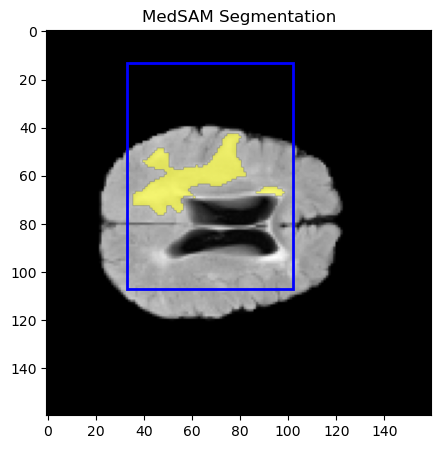

In [51]:
# 2d visualisation:
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))


slice_idx = 60
img_2d = img[..., slice_idx]
gt_2d = gt[..., slice_idx]
box = box_prompt.value[slice_idx]

img_2d = (img_2d-img_2d.min())/(img_2d.max()-img_2d.min())
#%% visualize results
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(img_2d, cmap = 'gray')
show_mask(gt_2d, ax)
show_box(box, ax)
ax.set_title("MedSAM Segmentation")
plt.show()